## ***Environment Setup***

In [0]:
import os
from pathlib import Path

In [0]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [0]:
DATA_DIR = Path('data/alien_vs_predator')
TEMP_DIR = Path('temp/alien_vs_predator')

In [0]:
FIRST_RUN = not os.path.exists("temp")

if FIRST_RUN:
    os.makedirs(TEMP_DIR, exist_ok=True)
    os.makedirs(DATA_DIR, exist_ok=True)

if FIRST_RUN:
    !pip install -q --upgrade scikit-optimize
    !pip install -q -U --pre efficientnet

In [0]:
def setup_kaggle():
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json

In [0]:
COLAB_ENVIRONMENT = FIRST_RUN

# Make sure you've uploaded 'kaggle.json' file into Colab
if COLAB_ENVIRONMENT:
    setup_kaggle()

In [0]:
DOWNLOAD_DATA = COLAB_ENVIRONMENT

if DOWNLOAD_DATA:
    !kaggle datasets download -d pmigdal/alien-vs-predator-images -p {str(DATA_DIR)} --unzip

In [0]:
if FIRST_RUN:
    exit()

## ***Importing Dependencies***

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras

TensorFlow 2.x selected.


In [0]:
# from toai.imports import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import efficientnet.tfkeras as efn
import shutil, pickle, PIL, math, skopt, time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix

from functools import partial
from mindpace import model_report

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
tf.__version__

'2.0.0-rc0'

## ***Dataset Description***

### **Content**

![Alien vs Predator](http://www.beartai.com/wp-content/uploads/2016/01/Aliens_Vs_Predator_Requiem_by_LuffyWKF-600x330.jpg)


Alien and Predator images (JPG, various ), for transfer learning. Split into Keras folder structure.

*Format:* JPG images, various thumbnail sizes (around 250 x 250 px).

*Volume:* train - 247 aliens and 247 predators; validation - 100 aliens and 100 predators.

###***Making image dataframes***

In [0]:
labels = ["alien", "predator"]
cols = ['Label', 'Path', 'Image', 'Full_Path', 'Width', 'Height']

In [0]:
def read_dir(label, cols, folder):
    file_list = list(os.listdir(DATA_DIR/folder/label.strip()))
    image_df = pd.DataFrame(columns=cols)
    image_df['Image'] = file_list
    image_df['Label'] = label
    image_df['Path'] = str(DATA_DIR/folder/label.strip())
    image_df['Full_Path'] = image_df['Path'] + '/' + image_df['Image']
    
    return image_df

In [0]:
def make_image_df(labels, cols, set_path):
    image_df = pd.DataFrame(columns=cols)

    for label in labels:
        image_df = image_df.append(read_dir(label, cols, set_path), ignore_index=True)
    
    for row in range(image_df.shape[0]):
        img_dims = PIL.Image.open(image_df.iloc[row]['Full_Path']).size
        image_df.iloc[row]['Width'] = img_dims[0]
        image_df.iloc[row]['Height'] = img_dims[1]
    
    return image_df

In [0]:
train_df = make_image_df(labels, cols, set_path='data/train')
test_df = make_image_df(labels, cols, set_path='data/validation')

In [0]:
train_df.head()

,Label,Path,Image,Full_Path,Width,Height
0,alien,data/alien_vs_predator/data/train/alien,326.jpg,data/alien_vs_predator/data/train/alien/326.jpg,197,255
1,alien,data/alien_vs_predator/data/train/alien,232.jpg,data/alien_vs_predator/data/train/alien/232.jpg,257,196
2,alien,data/alien_vs_predator/data/train/alien,106.jpg,data/alien_vs_predator/data/train/alien/106.jpg,300,168
3,alien,data/alien_vs_predator/data/train/alien,255.jpg,data/alien_vs_predator/data/train/alien/255.jpg,194,259
4,alien,data/alien_vs_predator/data/train/alien,327.jpg,data/alien_vs_predator/data/train/alien/327.jpg,283,178


In [0]:
train_df.tail()

,Label,Path,Image,Full_Path,Width,Height
689,predator,data/alien_vs_predator/data/train/predator,332.jpg,data/alien_vs_predator/data/train/predator/332...,259,194
690,predator,data/alien_vs_predator/data/train/predator,163.jpg,data/alien_vs_predator/data/train/predator/163...,225,225
691,predator,data/alien_vs_predator/data/train/predator,258.jpg,data/alien_vs_predator/data/train/predator/258...,193,261
692,predator,data/alien_vs_predator/data/train/predator,89.jpg,data/alien_vs_predator/data/train/predator/89.jpg,191,264
693,predator,data/alien_vs_predator/data/train/predator,88.jpg,data/alien_vs_predator/data/train/predator/88.jpg,190,266


###***Exploring image data***

In [0]:
df_dims = train_df.shape
print(f'Total number of images in training dataset is {df_dims[0]}.')

n_classes = train_df['Label'].nunique()
print(f'Total number of classes is {n_classes}.')

Total number of images in training dataset is 694.
Total number of classes is 2.


In [0]:
class_dist_df = train_df[['Image', 'Label']].groupby('Label', as_index=False).count()

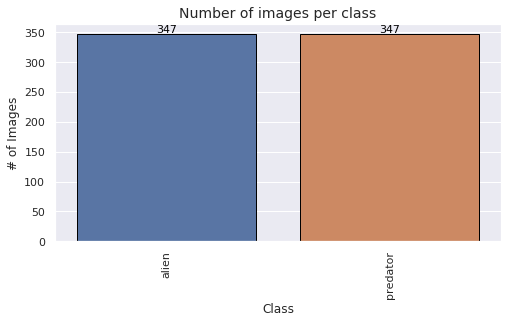

In [0]:
# setting plot style & size
sns.set(style='darkgrid')
plt.figure(figsize=(8, 4))

# rendering plot
sns.barplot(x='Label', y='Image', data=class_dist_df, edgecolor='black')

# adding chart title
plt.title('Number of images per class', size=14)

# adding custom labels for axes
plt.xlabel("Class")
plt.ylabel("# of Images")

# rotating axis labels
plt.xticks(rotation=90)

# adding labels on data points
for index, row in class_dist_df.iterrows():
    plt.text(row.name, row.Image + 2, row.Image, color='black', ha="center", size=11)

In [0]:
image_dims_df = train_df[['Label', 'Height', 'Width']]

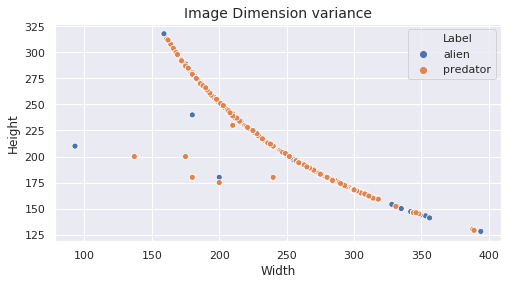

In [0]:
# setting plot style & size
sns.set(style='darkgrid')
plt.figure(figsize=(8, 4))

# adding chart title
plt.title('Image Dimension variance', size=14)

# rendering plot
sns.scatterplot(x='Width', y='Height', hue='Label', data=image_dims_df)

In [0]:
print(f"Image dimensions vary from {train_df['Height'].min()} to {train_df['Height'].max()} pixels in height.")
print(f"And from {train_df['Width'].min()} to {train_df['Width'].max()} pixels in width.")

Image dimensions vary from 128 to 318 pixels in height.
And from 93 to 394 pixels in width.


## ***Data Preparation***

###***Data Split - Train/Validation***

In [0]:
train_df, val_df = train_test_split(train_df, test_size=0.29, random_state=10, stratify=train_df['Label'])

In [0]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [0]:
# Checking the shapes of splited data
[x.shape for x in (train_df, val_df, test_df)]

[(492, 6), (202, 6), (200, 6)]

In [0]:
train_df.head()

,Label,Path,Image,Full_Path,Width,Height
0,predator,data/alien_vs_predator/data/train/predator,110.jpg,data/alien_vs_predator/data/train/predator/110...,199,253
1,alien,data/alien_vs_predator/data/train/alien,114.jpg,data/alien_vs_predator/data/train/alien/114.jpg,288,175
2,alien,data/alien_vs_predator/data/train/alien,84.jpg,data/alien_vs_predator/data/train/alien/84.jpg,259,194
3,alien,data/alien_vs_predator/data/train/alien,138.jpg,data/alien_vs_predator/data/train/alien/138.jpg,179,281
4,alien,data/alien_vs_predator/data/train/alien,54.jpg,data/alien_vs_predator/data/train/alien/54.jpg,263,192


### ***Data Preprocessing***

In [0]:
cat_cols = ['Label']

In [0]:
def cats_fit_transform(df, cat_cols):
    df = df.copy()
    cat_features_map = {}
    df[cat_cols] = df[cat_cols].astype('category')
    for cat_col in cat_cols:
        cat_features_map[cat_col] = dict(enumerate(df[cat_col].cat.categories))
        df[cat_col] = df[cat_col].cat.codes
    return df, cat_features_map

In [0]:
def cats_transform(df, cat_features_map):
    df = df.copy()
    for cat_col in cat_features_map:
        df[cat_col] = df[cat_col].map(
            {value: key for key, value in cat_features_map[cat_col].items()}
        )
        df[cat_col].fillna(value=0, inplace=True)
        df[cat_col] = df[cat_col].astype(int)
    return df

In [0]:
train_df, cat_features_map = cats_fit_transform(train_df, cat_cols)

In [0]:
train_df.head()

,Label,Path,Image,Full_Path,Width,Height
0,1,data/alien_vs_predator/data/train/predator,110.jpg,data/alien_vs_predator/data/train/predator/110...,199,253
1,0,data/alien_vs_predator/data/train/alien,114.jpg,data/alien_vs_predator/data/train/alien/114.jpg,288,175
2,0,data/alien_vs_predator/data/train/alien,84.jpg,data/alien_vs_predator/data/train/alien/84.jpg,259,194
3,0,data/alien_vs_predator/data/train/alien,138.jpg,data/alien_vs_predator/data/train/alien/138.jpg,179,281
4,0,data/alien_vs_predator/data/train/alien,54.jpg,data/alien_vs_predator/data/train/alien/54.jpg,263,192


In [0]:
print(cat_features_map)

{'Label': {0: 'alien', 1: 'predator'}}


In [0]:
# Saving feature mapping for categorical columns into the file
with open(TEMP_DIR/'cat_features_map.pkl', 'wb') as f:
    pickle.dump(cat_features_map, f, pickle.HIGHEST_PROTOCOL)

In [0]:
# Loading feature mapping for categorical columns from the file
with open(TEMP_DIR/'cat_features_map.pkl', 'rb') as f:
    cat_features_map = pickle.load(f)

In [0]:
print(cat_features_map)

{'Label': {0: 'alien', 1: 'predator'}}


In [0]:
classes = list(list(cat_features_map.values())[0].values())
print(classes)

['alien', 'predator']


In [0]:
val_df = cats_transform(val_df, cat_features_map)

In [0]:
val_df.head()

,Label,Path,Image,Full_Path,Width,Height
0,0,data/alien_vs_predator/data/train/alien,271.jpg,data/alien_vs_predator/data/train/alien/271.jpg,317,159
1,0,data/alien_vs_predator/data/train/alien,178.jpg,data/alien_vs_predator/data/train/alien/178.jpg,197,256
2,0,data/alien_vs_predator/data/train/alien,166.jpg,data/alien_vs_predator/data/train/alien/166.jpg,259,195
3,1,data/alien_vs_predator/data/train/predator,13.jpg,data/alien_vs_predator/data/train/predator/13.jpg,215,234
4,0,data/alien_vs_predator/data/train/alien,222.jpg,data/alien_vs_predator/data/train/alien/222.jpg,186,270


### ***Image Augementation***

In [0]:
target_col = 'Label'
image_path_col = 'Full_Path'
IMG_DIMS = (99, 99)

In [0]:
n_classes = train_df[target_col].nunique()

In [0]:
n_classes

2

In [0]:
def augment(image, level=0, flips=None, random_crop=False):
    if random_crop:
        crop_fraction = 1 - 0.05 * level
        scaled_dim = tf.to_int32(
            crop_fraction * tf.to_float(tf.reduce_min(tf.shape(image)[:2]))
        )
        image = tf.image.random_crop(image, (scaled_dim, scaled_dim, 3))
        image = tf.image.resize(image, IMG_DIMS)

    if flips in ["horizontal", "both"]:
        image = tf.image.random_flip_left_right(image)
    if flips in ["vertical", "both"]:
        image = tf.image.random_flip_up_down(image)

    if level > 0:
        lower = 1 - 0.1 * level
        upper = 1 + 0.1 * level
        image = tf.image.random_contrast(image, lower=lower, upper=upper)
        image = tf.image.random_saturation(image, lower=lower, upper=upper)
        image = tf.clip_by_value(image, 0.0, 1.0)
    return image

In [0]:
def image_parse(filename, preprocess_fn, img_dims, mode):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = preprocess_fn(image)
    if mode == "stretch":
        image = tf.image.resize(image, img_dims)
    elif mode == "crop":
        image = tf.image.resize_with_crop_or_pad(image, img_dims[0], img_dims[1])
    elif mode == "crop_stretch":
        image = tf.image.central_crop(image, central_fraction=1)
        image = tf.image.resize(image, img_dims)
    else:
        raise ValueError("mode not implemented")
    return image

In [0]:
def prepare_ds(
    df,
    x,
    y,
    batch_size,
    parse_fn,
    augment_fn,
    mode,
    prefetch=1,
    shuffle=False,
    num_parallel_calls=1,
):
    filenames = np.array([f"{getattr(row, x)}" for row in df.itertuples()])
    labels = df[y].values

    dataset_length = len(filenames)
    preprocess_fn = partial(tf.image.convert_image_dtype, dtype=tf.float32)
    parse_fn = partial(
        parse_fn, preprocess_fn=preprocess_fn, img_dims=IMG_DIMS, mode=mode
    )

    image_ds = (
        tf.data.Dataset.from_tensor_slices(filenames)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
    )
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))
    ds = tf.data.Dataset.zip((image_ds, label_ds))

    if shuffle:
        ds = ds.shuffle(dataset_length)

    ds = ds.batch(batch_size)
    ds = ds.repeat()
    if prefetch:
        ds = ds.prefetch(prefetch)
    return ds, dataset_length, batch_size

In [0]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    df=train_df,
    x=image_path_col,
    y=target_col,
    batch_size=32,
    parse_fn=image_parse,
    augment_fn=partial(augment, level=2, flips='both'),
    mode="crop_stretch",
    shuffle=True,
    prefetch=1,
    num_parallel_calls=-1,
)

In [0]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    df=val_df,
    x=image_path_col,
    y=target_col,
    batch_size=32,
    parse_fn=image_parse,
    augment_fn=augment,
    mode="crop_stretch",
    shuffle=False,
    prefetch=1,
    num_parallel_calls=-1,
)

In [0]:
def plot_dataset(dataset, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    for i, (x, y) in enumerate(dataset.take(rows * cols)):
        ax[i // cols, i % cols].axis('off')
        ax[i // cols, i % cols].imshow(x[0])
        ax[i // cols, i % cols].set_title(y[0].numpy())

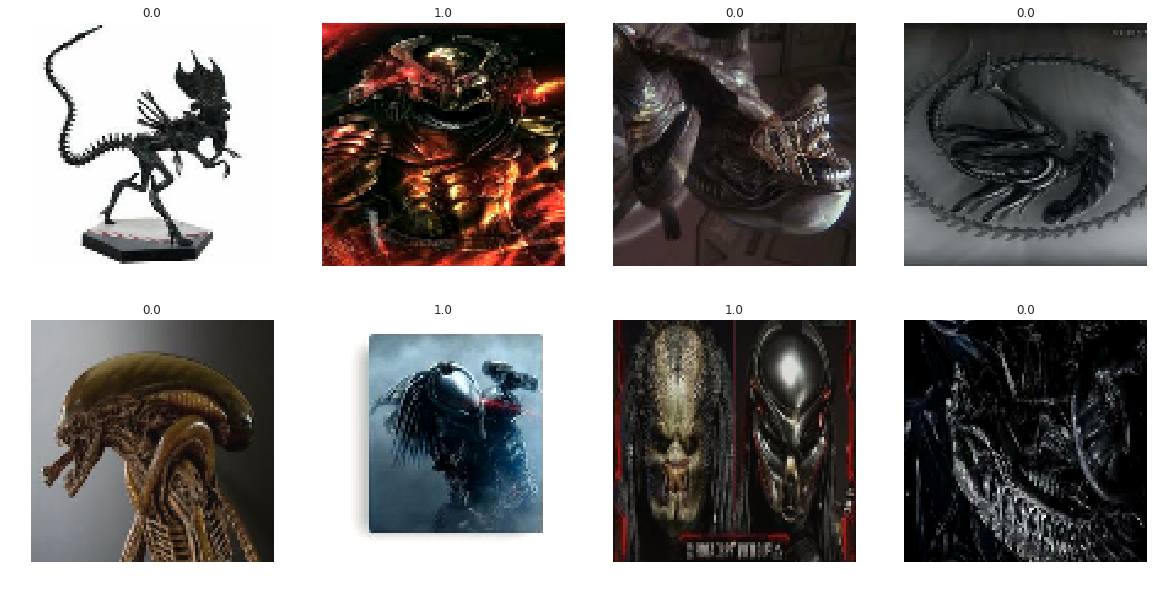

In [0]:
plot_dataset(train_dataset, 2, 4)

## ***Building Model***

### ***Image Classification Model***

In [0]:
def make_cnn_model(
    base_model,
    n_classes,
    input_shape,
    dropout_rate=0.0,
    l1=1e-8,
    l2=1e-8,
    weights='imagenet',
):
    base_model = base_model(include_top=False, input_shape=input_shape, weights=weights)
    x = keras.layers.concatenate([
        keras.layers.GlobalAvgPool2D()(base_model.output),
        keras.layers.GlobalMaxPool2D()(base_model.output),
    ])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    
    if n_classes > 2:
        activation_func=keras.activations.softmax
    else:
        activation_func=keras.activations.sigmoid
        if n_classes == 2:
            n_classes -= 1
    
    x = keras.layers.Dense(
        n_classes,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=activation_func,
    )(x)
        
    return keras.Model(inputs=base_model.inputs, outputs=x)

In [0]:
def train_cnn_model(
    base_model,
    optimizer,
    n_classes,
    input_shape,
    dropout=0.0,
    l1=3e-6,
    l2=3e-5,
    learn_rate=1e-4,
    epochs=15,
    easing_epochs=5,
    imagenet=True,
):
    
    if imagenet:
        weights = 'imagenet'
        print('Training Model with Transfer Learning ')
    else:
        weights = None
        print('Training Model without Transfer Learning ')
    
    model = make_cnn_model(
        base_model=base_model,
        n_classes=n_classes,
        input_shape=input_shape,
        dropout_rate=dropout,
        l1=l1,
        l2=l2,
        weights=weights,
    )
    
    if n_classes > 2:
        loss_func=keras.losses.sparse_categorical_crossentropy
        evaluation_metrics=[
            keras.metrics.sparse_categorical_accuracy,
        ]
    else:
        loss_func=keras.losses.binary_crossentropy
        evaluation_metrics=[
            keras.metrics.binary_accuracy,
        ]
    
    if easing_epochs:
        print("Frozen Layers' processing:")
        for layer in model.layers[:-1]:
            layer.trainable = False
        
        model.compile(
            optimizer=optimizer(learn_rate),
            loss=loss_func,
            metrics=evaluation_metrics,
        )

        easing_reduce_lr_patience = max(2, easing_epochs // 3)
        easing_early_stopping_patience = easing_reduce_lr_patience * 2
        
        model.fit(
            x=train_dataset,
            steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
            validation_data=val_dataset,
            validation_steps=math.ceil(val_dataset_length/val_batch_size),
            epochs=easing_epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=easing_reduce_lr_patience),
                keras.callbacks.EarlyStopping(patience=easing_early_stopping_patience, restore_best_weights=True),
            ],
            verbose=1,
        )        

        for layer in model.layers[:-1]:
            layer.trainable = True

    print("All Layers' processing:")
    model.compile(
        optimizer=optimizer(learn_rate),
        loss=loss_func,
        metrics=evaluation_metrics,
    )
    
    reduce_lr_patience = max(5, epochs // 4)
    early_stopping_patience = reduce_lr_patience * 2
    
    history = model.fit(
        x=train_dataset,
        steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(val_dataset_length/val_batch_size),
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=reduce_lr_patience),
            keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ],
        verbose=1,
    )
    
    return model, history

### ***Training Model w/o Transfer Learning***

In [0]:
# Preparing to capture models & metrics
model_metrics = pd.DataFrame(columns=['Precision', 'Accuracy', 'F1 score'])

In [0]:
cnn_noimgnet_model, cnn_noimgnet_history = train_cnn_model(
    base_model=keras.applications.Xception,
    optimizer=keras.optimizers.Adam,
    n_classes=n_classes,
    input_shape=IMG_DIMS + (3,),
    dropout=0.1,
    l1=0.01,
    l2=1e-8,
    learn_rate=3e-4,
    epochs=90,
    easing_epochs=0,
    imagenet=False,
)

Training Model without Transfer Learning 
All Layers' processing:
Train for 16 steps, validate for 7 steps
Epoch 1/90
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
16/16 [==============================] - 20s 1s/step - loss: 1.7545 - binary_accuracy: 0.6362 - val_loss: 1.4552 - val_binary_accuracy: 0.5000
Epoch 2/90
16/16 [==============================] - 5s 315ms/step - loss: 1.3760 - binary_accuracy: 0.7419 - val_loss: 1.4376 - val_binary_accuracy: 0.5000
Epoch 3/90
16/16 [==============================] - 5s 319ms/step - loss: 1.2722 - binary_accuracy: 0.7622 - val_loss: 1.4274 - val_binary_accuracy: 0.5000
Epoch 4/90
16/16 [==============================] - 5s 318ms/step - loss: 1.1995 - binary_accuracy: 0.8171 - val_loss: 1.4043 - val_binary_accuracy: 0.5000
Epoch 5/90
16/16 [==============================] - 5s 301ms/step - loss: 1.1646 - binary_accuracy: 0.8171 - val_loss: 1.4309 - val_binary_accuracy: 0.5000
Epoch 6/90
16/16 [===

In [0]:
def plot_history(history, contains, skip=0):
    df = pd.DataFrame(history.history)
    df[list(df.filter(regex=contains))].iloc[skip:].plot()

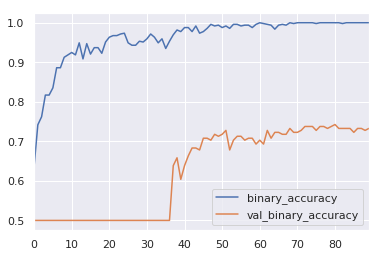

In [0]:
plot_history(cnn_noimgnet_history, 'accuracy')

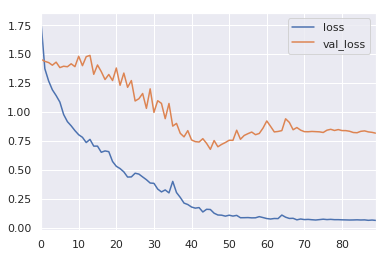

In [0]:
plot_history(cnn_noimgnet_history, 'loss')

In [0]:
def model_predict(model, dataset, step):
    preds = model.predict(dataset, steps=step)
    labels = np.concatenate([
        y.numpy() for _, y in dataset.take(step)
    ])
    return preds, labels

In [0]:
val_predictions, val_labels = model_predict(
    cnn_noimgnet_model,
    val_dataset,
    step=math.ceil(val_dataset_length/val_batch_size),
)

Precision score: 70.79%
Accuracy score: 70.79%
F1 score: 70.79%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71       101
         1.0       0.71      0.70      0.71       101

    accuracy                           0.71       202
   macro avg       0.71      0.71      0.71       202
weighted avg       0.71      0.71      0.71       202



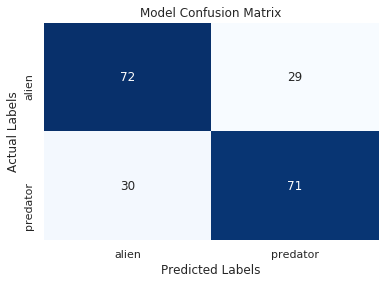

In [0]:
model_report(val_labels, val_predictions, n_classes, classes, all_metrics=True)

In [0]:
# Evaluating models
def model_evaluate(model, dataset, dataset_length, batch_size):
    
    # Predicting on dataset
    preds, labels = model_predict(
        model,
        dataset,
        step=math.ceil(dataset_length/batch_size),
    )

    # Evaluating model
    model_prec = precision_score(labels, preds > 0.5, average='weighted')
    model_accu = accuracy_score(labels, preds > 0.5)
    model_f1 = f1_score(labels, preds > 0.5, average='weighted')
    
    return model_prec, model_accu, model_f1

In [0]:
model_name = 'wo Transfer Learning'
model_prec, model_accu, model_f1 = model_evaluate(cnn_noimgnet_model, val_dataset, val_dataset_length, val_batch_size)
model_metrics.loc[model_name, 'Precision'] = model_prec
model_metrics.loc[model_name, 'Accuracy'] = model_accu
model_metrics.loc[model_name, 'F1 score'] = model_f1

### ***Training TL (Xception) Model w/o Frozen Layers***

In [0]:
# Dimensions:
# Optimizer - Adam, Epochs - 30, Frozen epochs 0,
# Learning rate - 0.00029182199245194246, Dropout - 0.1, l1 - 0.01, l2 - 1e-08

cnn_model, cnn_history = train_cnn_model(
    base_model = keras.applications.Xception,
    optimizer=keras.optimizers.Adam,
    n_classes=n_classes,
    input_shape=IMG_DIMS + (3,),
    dropout=0.1,
    l1=0.01,
    l2=1e-8,
    learn_rate=3e-4,
    epochs=30,
    easing_epochs=0,
)

Training Model with Transfer Learning 
All Layers' processing:
Train for 16 steps, validate for 7 steps
Epoch 1/30
16/16 [==============================] - 16s 981ms/step - loss: 1.3439 - binary_accuracy: 0.7297 - val_loss: 1.2059 - val_binary_accuracy: 0.7822
Epoch 2/30
16/16 [==============================] - 5s 317ms/step - loss: 1.0195 - binary_accuracy: 0.8862 - val_loss: 1.0901 - val_binary_accuracy: 0.8465
Epoch 3/30
16/16 [==============================] - 5s 299ms/step - loss: 1.0026 - binary_accuracy: 0.8943 - val_loss: 1.0916 - val_binary_accuracy: 0.8614
Epoch 4/30
16/16 [==============================] - 5s 326ms/step - loss: 0.9099 - binary_accuracy: 0.9451 - val_loss: 1.0443 - val_binary_accuracy: 0.8564
Epoch 5/30
16/16 [==============================] - 5s 300ms/step - loss: 0.8263 - binary_accuracy: 0.9451 - val_loss: 1.1759 - val_binary_accuracy: 0.7921
Epoch 6/30
16/16 [==============================] - 5s 311ms/step - loss: 0.7692 - binary_accuracy: 0.9512 - val_lo

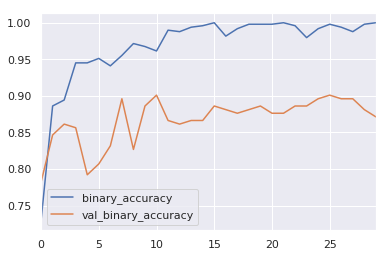

In [0]:
plot_history(cnn_history, 'accuracy')

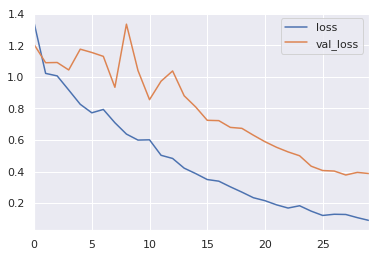

In [0]:
plot_history(cnn_history, 'loss')

In [0]:
val_predictions, val_labels = model_predict(
    cnn_model,
    val_dataset,
    step=math.ceil(val_dataset_length/val_batch_size),
)

Precision score: 87.50%
Accuracy score: 87.13%
F1 score: 87.10%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       101
         1.0       0.91      0.82      0.86       101

    accuracy                           0.87       202
   macro avg       0.87      0.87      0.87       202
weighted avg       0.87      0.87      0.87       202



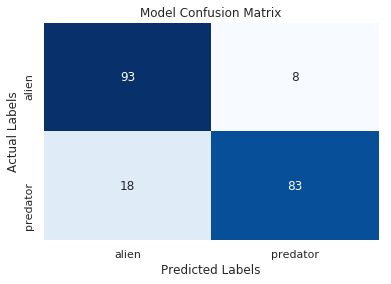

In [0]:
model_report(val_labels, val_predictions, n_classes, classes, all_metrics=True)

In [0]:
model_name = 'TL (Xception) wo Frozen Layers'
model_prec, model_accu, model_f1 = model_evaluate(cnn_model, val_dataset, val_dataset_length, val_batch_size)
model_metrics.loc[model_name, 'Precision'] = model_prec
model_metrics.loc[model_name, 'Accuracy'] = model_accu
model_metrics.loc[model_name, 'F1 score'] = model_f1

### ***Training TL (Xception) Model with Frozen Layers***

In [0]:
cnn_tuned_model, cnn_tuned_history = train_cnn_model(
    base_model = keras.applications.Xception,
    optimizer=keras.optimizers.Adam,
    n_classes=n_classes,
    input_shape=IMG_DIMS + (3,),
    dropout=0.1,
    l1=0.01,
    l2=1e-8,
    learn_rate=3e-4,
    epochs=25,
    easing_epochs=5,
)

Training Model with Transfer Learning 
Frozen Layers' processing:
Train for 16 steps, validate for 7 steps
Epoch 1/5
16/16 [==============================] - 8s 490ms/step - loss: 1.4647 - binary_accuracy: 0.5183 - val_loss: 1.4685 - val_binary_accuracy: 0.5050
Epoch 2/5
16/16 [==============================] - 2s 151ms/step - loss: 1.3726 - binary_accuracy: 0.5874 - val_loss: 1.3506 - val_binary_accuracy: 0.6089
Epoch 3/5
16/16 [==============================] - 2s 143ms/step - loss: 1.2871 - binary_accuracy: 0.6707 - val_loss: 1.2759 - val_binary_accuracy: 0.6436
Epoch 4/5
16/16 [==============================] - 2s 151ms/step - loss: 1.2259 - binary_accuracy: 0.6748 - val_loss: 1.1692 - val_binary_accuracy: 0.7079
Epoch 5/5
16/16 [==============================] - 2s 153ms/step - loss: 1.1744 - binary_accuracy: 0.6972 - val_loss: 1.0949 - val_binary_accuracy: 0.7079
All Layers' processing:
Train for 16 steps, validate for 7 steps
Epoch 1/25
16/16 [==============================] - 1

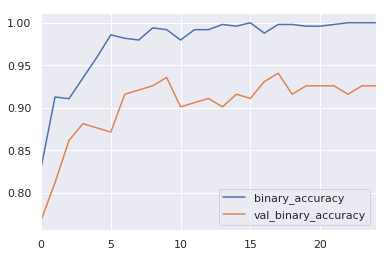

In [0]:
plot_history(cnn_tuned_history, 'accuracy')

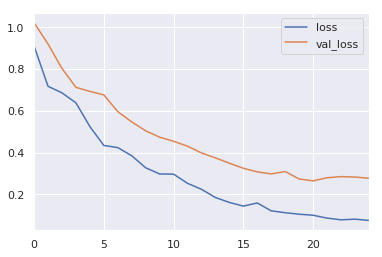

In [0]:
plot_history(cnn_tuned_history, 'loss')

In [0]:
val_predictions, val_labels = model_predict(
    cnn_tuned_model,
    val_dataset,
    step=math.ceil(val_dataset_length/val_batch_size),
)

Precision score: 92.61%
Accuracy score: 92.57%
F1 score: 92.57%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       101
         1.0       0.94      0.91      0.92       101

    accuracy                           0.93       202
   macro avg       0.93      0.93      0.93       202
weighted avg       0.93      0.93      0.93       202



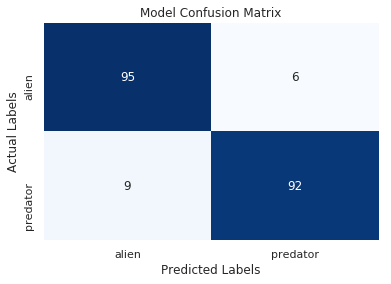

In [0]:
model_report(val_labels, val_predictions, n_classes, classes, all_metrics=True)

In [0]:
model_name = 'TL (Xception) with Frozen Layers'
model_prec, model_accu, model_f1 = model_evaluate(cnn_tuned_model, val_dataset, val_dataset_length, val_batch_size)
model_metrics.loc[model_name, 'Precision'] = model_prec
model_metrics.loc[model_name, 'Accuracy'] = model_accu
model_metrics.loc[model_name, 'F1 score'] = model_f1

### ***Training TL (DenseNet169) Model with Frozen Layers***

In [0]:
cnn_tuned_model2, cnn_tuned_history2 = train_cnn_model(
    base_model = keras.applications.DenseNet169,
    optimizer=keras.optimizers.Adam,
    n_classes=n_classes,
    input_shape=IMG_DIMS + (3,),
    dropout=0.1,
    l1=0.01,
    l2=1e-8,
    learn_rate=3e-4,
    epochs=25,
    easing_epochs=5,
)

Training Model with Transfer Learning 
Frozen Layers' processing:
Train for 16 steps, validate for 7 steps
Epoch 1/5
16/16 [==============================] - 21s 1s/step - loss: 1.6133 - binary_accuracy: 0.4980 - val_loss: 1.5672 - val_binary_accuracy: 0.5297
Epoch 2/5
16/16 [==============================] - 3s 183ms/step - loss: 1.2756 - binary_accuracy: 0.6179 - val_loss: 1.3776 - val_binary_accuracy: 0.5842
Epoch 3/5
16/16 [==============================] - 3s 180ms/step - loss: 1.1620 - binary_accuracy: 0.6545 - val_loss: 1.1879 - val_binary_accuracy: 0.6139
Epoch 4/5
16/16 [==============================] - 3s 178ms/step - loss: 1.0277 - binary_accuracy: 0.7215 - val_loss: 1.1402 - val_binary_accuracy: 0.6139
Epoch 5/5
16/16 [==============================] - 3s 182ms/step - loss: 0.9742 - binary_accuracy: 0.7033 - val_loss: 1.0399 - val_binary_accuracy: 0.6535
All Layers' processing:
Train for 16 steps, validate for 7 steps
Epoch 1/25
16/16 [==============================] - 48s

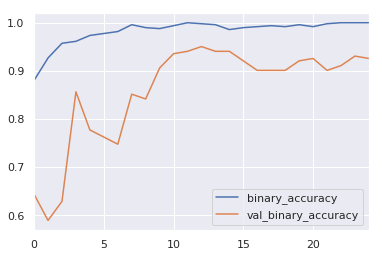

In [0]:
plot_history(cnn_tuned_history2, 'accuracy')

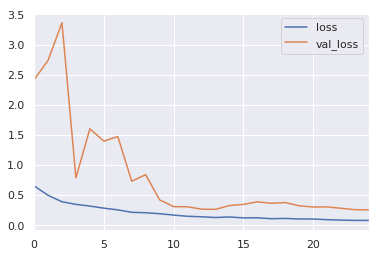

In [0]:
plot_history(cnn_tuned_history2, 'loss')

In [0]:
val_predictions, val_labels = model_predict(
    cnn_tuned_model2,
    val_dataset,
    step=math.ceil(val_dataset_length/val_batch_size),
)

Precision score: 92.78%
Accuracy score: 92.57%
F1 score: 92.57%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       101
         1.0       0.96      0.89      0.92       101

    accuracy                           0.93       202
   macro avg       0.93      0.93      0.93       202
weighted avg       0.93      0.93      0.93       202



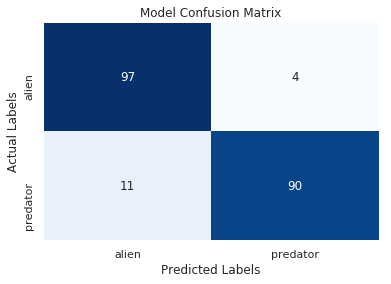

In [0]:
model_report(val_labels, val_predictions, n_classes, classes, all_metrics=True)

In [0]:
model_name = 'TL (DenseNet169) with Frozen Layers'
model_prec, model_accu, model_f1 = model_evaluate(cnn_tuned_model2, val_dataset, val_dataset_length, val_batch_size)
model_metrics.loc[model_name, 'Precision'] = model_prec
model_metrics.loc[model_name, 'Accuracy'] = model_accu
model_metrics.loc[model_name, 'F1 score'] = model_f1

### ***Training Combined Architecture Model***

In [0]:
def make_combined_model(
    base_models,
    n_classes,
    input_shape,
    dropout_rate=0.0,
    l1=1e-8,
    l2=1e-8,
    weights='imagenet',
):
    model_input = keras.layers.Input(shape=input_shape)
    
    x1 = base_models[0](include_top=False, weights=weights)(model_input)
    x1 = keras.layers.concatenate([
        keras.layers.GlobalAvgPool2D()(x1),
        keras.layers.GlobalMaxPool2D()(x1),
    ])
    
    x2 = base_models[1](include_top=False, weights=weights)(model_input)
    x2 = keras.layers.concatenate([
        keras.layers.GlobalAvgPool2D()(x2),
        keras.layers.GlobalMaxPool2D()(x2),
    ])

    x = keras.layers.concatenate([x1, x2], axis=1)
    
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    
    if n_classes > 2:
        activation_func=keras.activations.softmax
    else:
        activation_func=keras.activations.sigmoid
        if n_classes == 2:
            n_classes -= 1
    
    x = keras.layers.Dense(
        n_classes,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=activation_func,
    )(x)
        
    return keras.Model(inputs=model_input, outputs=x)

In [0]:
def train_combined_model(
    base_models,
    optimizer,
    n_classes,
    input_shape,
    dropout=0.0,
    l1=3e-6,
    l2=3e-5,
    learn_rate=1e-4,
    epochs=15,
    easing_epochs=5,
    imagenet=True,
):
    
    if imagenet:
        weights = 'imagenet'
        print('Training Model with Transfer Learning ')
    else:
        weights = None
        print('Training Model without Transfer Learning ')
    
    model = make_combined_model(
        base_models=base_models,
        n_classes=n_classes,
        input_shape=input_shape,
        dropout_rate=dropout,
        l1=l1,
        l2=l2,
        weights=weights,
    )
    
    if n_classes > 2:
        loss_func=keras.losses.sparse_categorical_crossentropy
        evaluation_metrics=[
            keras.metrics.sparse_categorical_accuracy,
        ]
    else:
        loss_func=keras.losses.binary_crossentropy
        evaluation_metrics=[
            keras.metrics.binary_accuracy,
        ]
    
    if easing_epochs:
        print("Frozen Layers' processing:")
        for layer in model.layers[:-1]:
            layer.trainable = False
        
        model.compile(
            optimizer=optimizer(learn_rate),
            loss=loss_func,
            metrics=evaluation_metrics,
        )

        easing_reduce_lr_patience = max(2, easing_epochs // 3)
        easing_early_stopping_patience = easing_reduce_lr_patience * 2
        
        model.fit(
            x=train_dataset,
            steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
            validation_data=val_dataset,
            validation_steps=math.ceil(val_dataset_length/val_batch_size),
            epochs=easing_epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=easing_reduce_lr_patience),
                keras.callbacks.EarlyStopping(patience=easing_early_stopping_patience, restore_best_weights=True),
            ],
            verbose=1,
        )        

        for layer in model.layers[:-1]:
            layer.trainable = True

    print("All Layers' processing:")
    model.compile(
        optimizer=optimizer(learn_rate),
        loss=loss_func,
        metrics=evaluation_metrics,
    )
    
    reduce_lr_patience = max(5, epochs // 4)
    early_stopping_patience = reduce_lr_patience * 2
    
    history = model.fit(
        x=train_dataset,
        steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(val_dataset_length/val_batch_size),
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=reduce_lr_patience),
            keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ],
        verbose=1,
    )
    
    return model, history

In [0]:
combined_model, combined_history = train_combined_model(
    base_models = [
        keras.applications.Xception,
        keras.applications.DenseNet169,
    ],
    optimizer=keras.optimizers.Adam,
    n_classes=n_classes,
    input_shape=IMG_DIMS + (3,),
    dropout=0.1,
    l1=0.01,
    l2=1e-8,
    learn_rate=3e-4,
    epochs=25,
    easing_epochs=5,
)

Training Model with Transfer Learning 
Frozen Layers' processing:
Train for 16 steps, validate for 7 steps
Epoch 1/5
16/16 [==============================] - 24s 2s/step - loss: 1.7615 - binary_accuracy: 0.5122 - val_loss: 1.6613 - val_binary_accuracy: 0.6040
Epoch 2/5
16/16 [==============================] - 4s 264ms/step - loss: 1.4584 - binary_accuracy: 0.6687 - val_loss: 1.4227 - val_binary_accuracy: 0.6683
Epoch 3/5
16/16 [==============================] - 4s 261ms/step - loss: 1.2630 - binary_accuracy: 0.7459 - val_loss: 1.2599 - val_binary_accuracy: 0.6980
Epoch 4/5
16/16 [==============================] - 4s 257ms/step - loss: 1.0961 - binary_accuracy: 0.7967 - val_loss: 1.1512 - val_binary_accuracy: 0.7327
Epoch 5/5
16/16 [==============================] - 4s 268ms/step - loss: 0.9893 - binary_accuracy: 0.8069 - val_loss: 1.0843 - val_binary_accuracy: 0.7574
All Layers' processing:
Train for 16 steps, validate for 7 steps
Epoch 1/25
16/16 [==============================] - 63s

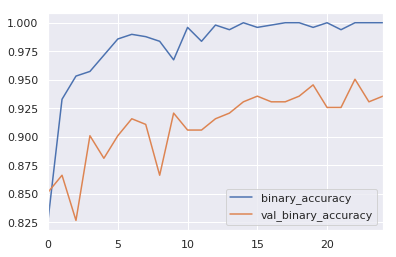

In [0]:
plot_history(combined_history, 'accuracy')

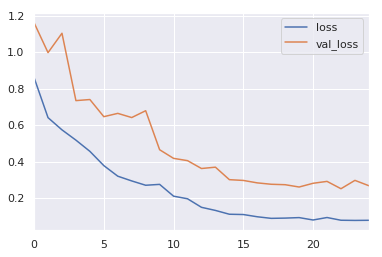

In [0]:
plot_history(combined_history, 'loss')

In [0]:
val_predictions, val_labels = model_predict(
    combined_model,
    val_dataset,
    step=math.ceil(val_dataset_length/val_batch_size),
)

Precision score: 93.77%
Accuracy score: 93.56%
F1 score: 93.56%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       101
         1.0       0.97      0.90      0.93       101

    accuracy                           0.94       202
   macro avg       0.94      0.94      0.94       202
weighted avg       0.94      0.94      0.94       202



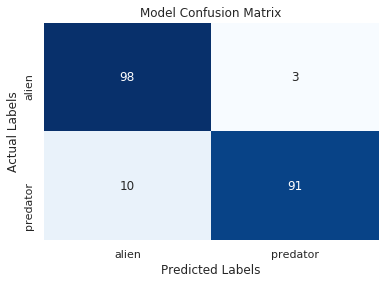

In [0]:
model_report(val_labels, val_predictions, n_classes, classes, all_metrics=True)

In [0]:
model_name = 'Combined TL (Xception & DenseNet169) with Frozen Layers'
model_prec, model_accu, model_f1 = model_evaluate(combined_model, val_dataset, val_dataset_length, val_batch_size)
model_metrics.loc[model_name, 'Precision'] = model_prec
model_metrics.loc[model_name, 'Accuracy'] = model_accu
model_metrics.loc[model_name, 'F1 score'] = model_f1

In [0]:
model_metrics

,Precision,Accuracy,F1 score
wo Transfer Learning,0.707941,0.707921,0.707914
TL (Xception) wo Frozen Layers,0.874963,0.871287,0.870971
TL (Xception) with Frozen Layers,0.926119,0.925743,0.925726
TL (DenseNet169) with Frozen Layers,0.927797,0.925743,0.925653
Combined TL (Xception & DenseNet169) with Frozen Layers,0.937746,0.935644,0.935566


## ***Exploring Different Model Architectures***

In [0]:
# Preparing to capture models & metrics
arch_model_metrics = pd.DataFrame(columns=['Train Time', 'Eval Time', 'Loss', 'Precision', 'Accuracy', 'F1 score'])
base_model_list = [
    (keras.applications.ResNet50V2, 'ResNet50V2'),
    (keras.applications.DenseNet121, 'DenseNet121'),
    (keras.applications.MobileNetV2, 'MobileNetV2'),
    (keras.applications.InceptionV3, 'InceptionV3'),
    (keras.applications.ResNet101V2, 'ResNet101V2'),
    (keras.applications.DenseNet169, 'DenseNet169'),
    (keras.applications.Xception, 'Xception'),
    (keras.applications.ResNet152V2, 'ResNet152V2'),
    (keras.applications.DenseNet201, 'DenseNet201'),
    (keras.applications.InceptionResNetV2, 'InceptionResNetV2'),
#     keras.applications.NASNetMobile,
    (efn.EfficientNetB0, 'EfficientNetB0'),
    (efn.EfficientNetB1, 'EfficientNetB1'),
    (efn.EfficientNetB2, 'EfficientNetB2'),
    (efn.EfficientNetB3, 'EfficientNetB3'),
    (efn.EfficientNetB4, 'EfficientNetB4'),
    (efn.EfficientNetB5, 'EfficientNetB5'),
    (efn.EfficientNetB6, 'EfficientNetB6'),
]

In [0]:
for base_model, model_name in base_model_list:
    
    print("\nBase Model Architecture -", model_name)
    start_time = time.time()
    cnn_base_model, cnn_base_history = train_cnn_model(
        base_model=base_model,
        optimizer=keras.optimizers.Adam,
        n_classes=n_classes,
        input_shape=IMG_DIMS + (3,),
        dropout=0.1,
        l1=0.01,
        l2=1e-8,
        learn_rate=3e-4,
        epochs=25,
        easing_epochs=5,
    )
    end_time = time.time()
    
    eval_start_time = time.time()
    loss, accuracy = cnn_base_model.evaluate(val_dataset, steps=math.ceil(val_dataset_length/val_batch_size))
    eval_end_time = time.time()
    
    print("------------".center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            model_name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("------------".center(80, "-"))
    
    model_prec, model_accu, model_f1 = model_evaluate(cnn_base_model, val_dataset, val_dataset_length, val_batch_size)
    arch_model_metrics.loc[model_name, 'Train Time'] = (end_time - start_time) / 60
    arch_model_metrics.loc[model_name, 'Eval Time'] = (eval_end_time - eval_start_time)
    arch_model_metrics.loc[model_name, 'Loss'] = loss
    arch_model_metrics.loc[model_name, 'Precision'] = model_prec
    arch_model_metrics.loc[model_name, 'Accuracy'] = model_accu
    arch_model_metrics.loc[model_name, 'F1 score'] = model_f1
    
    del cnn_base_model


Base Model Architecture - ResNet50V2
Training Model with Transfer Learning 
94674944/94668760 [==============================] - 1s 0us/step
Frozen Layers' processing:
Train for 16 steps, validate for 7 steps
Epoch 1/5
16/16 [==============================] - 9s 576ms/step - loss: 2.1104 - binary_accuracy: 0.5264 - val_loss: 2.0980 - val_binary_accuracy: 0.5149
Epoch 2/5
16/16 [==============================] - 2s 144ms/step - loss: 1.8408 - binary_accuracy: 0.6118 - val_loss: 1.8193 - val_binary_accuracy: 0.5842
Epoch 3/5
16/16 [==============================] - 2s 139ms/step - loss: 1.5329 - binary_accuracy: 0.6646 - val_loss: 1.6784 - val_binary_accuracy: 0.6337
Epoch 4/5
16/16 [==============================] - 2s 146ms/step - loss: 1.4631 - binary_accuracy: 0.6951 - val_loss: 1.6586 - val_binary_accuracy: 0.6881
Epoch 5/5
16/16 [==============================] - 2s 142ms/step - loss: 1.2774 - binary_accuracy: 0.7622 - val_loss: 1.6541 - val_binary_accuracy: 0.6980
All Layers' pro

/tensorflow-2.0.0-rc0/python3.6/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step
Frozen Layers' processing:
Train for 16 steps, validate for 7 steps
Epoch 1/5
16/16 [==============================] - 7s 446ms/step - loss: 1.8809 - binary_accuracy: 0.4939 - val_loss: 1.9697 - val_binary_accuracy: 0.5347
Epoch 2/5
16/16 [==============================] - 1s 89ms/step - loss: 1.5599 - binary_accuracy: 0.5996 - val_loss: 1.4942 - val_binary_accuracy: 0.6040
Epoch 3/5
16/16 [==============================] - 2s 97ms/step - loss: 1.4796 - binary_accuracy: 0.6077 - val_loss: 1.4473 - val_binary_accuracy: 0.6337
Epoch 4/5
16/16 [==============================] - 2s 97ms/step - loss: 1.2989 - binary_accuracy: 0.6646 - val_loss: 1.3106 - val_binary_accuracy: 0.6436
Epoch 5/5
16/16 [==============================] - 2s 104ms/step - loss: 1.2414 - binary_accuracy: 0.6890 - val_loss: 1.2310 - val_binary_accuracy: 0.6782
All Layers' processing:
Train for 16 steps, validate for 7 steps
Epoch 1/25
16/16 [==============

In [0]:
arch_model_metrics.sort_values(by='F1 score', ascending=False)

,Train Time,Eval Time,Loss,Precision,Accuracy,F1 score
EfficientNetB2,3.05809,0.535168,0.244081,0.950495,0.950495,0.950495
DenseNet169,3.68075,0.663833,0.217429,0.940767,0.940594,0.940588
EfficientNetB3,3.49787,0.614363,0.246773,0.935686,0.935644,0.935642
DenseNet121,2.79739,0.487911,0.230778,0.936714,0.935644,0.935604
EfficientNetB0,2.17487,0.397138,0.277116,0.926789,0.925743,0.925697
EfficientNetB4,4.54119,0.807711,0.306361,0.920792,0.920792,0.920792
EfficientNetB1,3.04785,0.513897,0.315285,0.920957,0.920792,0.920784
EfficientNetB5,5.94715,1.03933,0.304425,0.923449,0.920792,0.920668
ResNet50V2,2.61283,0.532715,0.407481,0.90598,0.905941,0.905938
InceptionResNetV2,5.16153,0.930232,0.571919,0.90598,0.905941,0.905938


In [0]:
print('Best performers by different metrics:\n')
for col in ['Train Time', 'Eval Time', 'Loss']:
    print(f'{col} of {arch_model_metrics[col].min():.4f} with {arch_model_metrics[col].astype(float).idxmin()} architecture.')

for col in ['Precision', 'Accuracy', 'F1 score']:
    print(f'{col} of {arch_model_metrics[col].max():.2%} with {arch_model_metrics[col].astype(float).idxmax()} architecture.')

Best performers by different metrics:

Train Time of 1.0735 with MobileNetV2 architecture.
Eval Time of 0.3396 with MobileNetV2 architecture.
Loss of 0.2174 with DenseNet169 architecture.
Precision of 95.05% with EfficientNetB2 architecture.
Accuracy of 95.05% with EfficientNetB2 architecture.
F1 score of 95.05% with EfficientNetB2 architecture.


In [0]:
print('Worst performers by different metrics:\n')
for col in ['Train Time', 'Eval Time', 'Loss']:
    print(f'{col} of {arch_model_metrics[col].max():.4f} with {arch_model_metrics[col].astype(float).idxmax()} architecture.')

for col in ['Precision', 'Accuracy', 'F1 score']:
    print(f'{col} of {arch_model_metrics[col].min():.2%} with {arch_model_metrics[col].astype(float).idxmin()} architecture.')

Worst performers by different metrics:

Train Time of 7.4380 with EfficientNetB6 architecture.
Eval Time of 1.2899 with EfficientNetB6 architecture.
Loss of 1.1626 with MobileNetV2 architecture.
Precision of 82.38% with MobileNetV2 architecture.
Accuracy of 82.18% with MobileNetV2 architecture.
F1 score of 82.15% with MobileNetV2 architecture.


## ***Hyperparameter Tuning***

In [0]:
dimensions = [
    skopt.space.Categorical([
        keras.optimizers.Adam,
        keras.optimizers.Nadam,
        keras.optimizers.RMSprop,
        keras.optimizers.SGD,
    ], name='optimizer'),
    skopt.space.Real(low=1e-6, high=3e-3, prior='log-uniform', name='lr'),
    skopt.space.Real(low=0.1, high=0.6, name='dropout'),
    skopt.space.Real(low=1e-8, high=1e-2, prior='log-uniform', name='l1'),
    skopt.space.Real(low=1e-8, high=1e-2, prior='log-uniform', name='l2'),
    skopt.space.Integer(low=6, high=30, name='epochs'),
    skopt.space.Integer(low=0, high=10, name='easing_epochs'),
]

In [0]:
default_parameters = [keras.optimizers.Adam, 3e-4, 0.1, 0.01, 1e-8, 25, 5]

In [0]:
best_accuracy = 0.0
best_model_arch_path = str(TEMP_DIR/'best_model.json')
best_model_weights_path = str(TEMP_DIR/'best_model.h5')

In [0]:
input_shape = IMG_DIMS + (3,)

In [0]:
@skopt.utils.use_named_args(dimensions=dimensions)
def fitness(
    optimizer,
    lr,
    dropout,
    l1,
    l2,
    epochs,
    easing_epochs,
):
    base_model = keras.applications.Xception
    
    model, history = train_cnn_model(
        base_model=base_model,
        optimizer=optimizer,
        n_classes=n_classes,
        input_shape=input_shape,
        dropout=dropout,
        l1=l1,
        l2=l2,
        learn_rate=lr,
        epochs=epochs,
        easing_epochs=easing_epochs,
    )

    accuracy = max(history.history['val_binary_accuracy'])
    
    print(f'Accuracy: {accuracy:.2%}')
    
    global best_accuracy
    
    if accuracy > best_accuracy:
        print(' Best model '.center(80, '-'))
        model.save_weights(best_model_weights_path)
        with open(best_model_arch_path, 'w') as f:
            f.write(model.to_json())
        best_accuracy = accuracy

    print('Dimensions:')
    print(f'Optimizer - {optimizer.__name__}, Epochs - {epochs}, Frozen epochs {easing_epochs},')
    print(f'Learning rate - {lr}, Dropout - {dropout}, l1 - {l1}, l2 - {l2}\n')

    del model
    
    keras.backend.clear_session()
    
    return -accuracy

In [0]:
search_result = skopt.gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI',
    n_calls=20,
    x0=default_parameters,
)

Training Model with Transfer Learning 
Frozen Layers' processing:
Train for 16 steps, validate for 7 steps
Epoch 1/5
16/16 [==============================] - 8s 511ms/step - loss: 1.4592 - binary_accuracy: 0.5589 - val_loss: 1.3575 - val_binary_accuracy: 0.6584
Epoch 2/5
16/16 [==============================] - 3s 157ms/step - loss: 1.3718 - binary_accuracy: 0.6199 - val_loss: 1.2762 - val_binary_accuracy: 0.6782
Epoch 3/5
16/16 [==============================] - 2s 151ms/step - loss: 1.2901 - binary_accuracy: 0.6789 - val_loss: 1.1964 - val_binary_accuracy: 0.7277
Epoch 4/5
16/16 [==============================] - 2s 144ms/step - loss: 1.2408 - binary_accuracy: 0.7093 - val_loss: 1.1262 - val_binary_accuracy: 0.7475
Epoch 5/5
16/16 [==============================] - 2s 155ms/step - loss: 1.1712 - binary_accuracy: 0.6850 - val_loss: 1.0737 - val_binary_accuracy: 0.7624
All Layers' processing:
Train for 16 steps, validate for 7 steps
Epoch 1/25
16/16 [==============================] - 1

In [0]:
{key.name: value for key, value in zip(dimensions, search_result.x)}

{'dropout': 0.5961095011652897,
 'easing_epochs': 7,
 'epochs': 30,
 'l1': 0.01,
 'l2': 1e-08,
 'lr': 0.0005236491345295089,
 'optimizer': tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop}

In [0]:
# Loading saved model
def load_model(arch, weights):
    with open(arch, "r") as f:
        model = keras.models.model_from_json(f.read())
    model.load_weights(weights)
    return model

In [0]:
loaded_model = load_model(best_model_arch_path, best_model_weights_path)

In [0]:
# Compiling loaded model
if n_classes > 2:
    loaded_model.compile(
        optimizer=keras.optimizers.SGD(1),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
        ],
    )
else:
    loaded_model.compile(
        optimizer=keras.optimizers.SGD(1),
        loss=keras.losses.binary_crossentropy,
        metrics=[
            keras.metrics.binary_accuracy,
        ],
    )

In [0]:
loaded_model.evaluate(val_dataset, steps=math.ceil(val_dataset_length/val_batch_size))

7/7 [==============================] - 2s 240ms/step - loss: 0.3242 - binary_accuracy: 0.9257


[0.3241951933928898, 0.92574257]

In [0]:
val_predictions, val_labels = model_predict(
    loaded_model,
    val_dataset,
    step=math.ceil(val_dataset_length/val_batch_size),
)

Precision score: 92.78%
Accuracy score: 92.57%
F1 score: 92.57%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       101
         1.0       0.96      0.89      0.92       101

    accuracy                           0.93       202
   macro avg       0.93      0.93      0.93       202
weighted avg       0.93      0.93      0.93       202



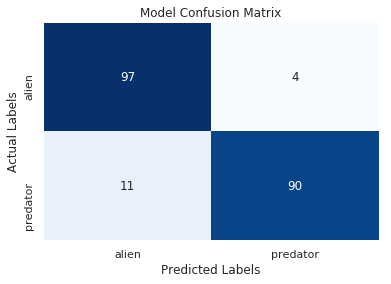

In [0]:
model_report(val_labels, val_predictions, n_classes, classes, all_metrics=True)

## ***Final Model Testing***

In [0]:
test_df = cats_transform(test_df, cat_features_map)

In [0]:
test_dataset, test_dataset_length, test_batch_size = prepare_ds(
    df=test_df,
    x=image_path_col,
    y=target_col,
    batch_size=32,
    parse_fn=image_parse,
    augment_fn=augment,
    mode="crop_stretch",
    shuffle=False,
    prefetch=1,
    num_parallel_calls=-1,
)

In [0]:
test_predictions, test_labels = model_predict(
    loaded_model,
    test_dataset,
    step=math.ceil(test_dataset_length/test_batch_size),
)

Precision score: 91.60%
Accuracy score: 91.50%
F1 score: 91.49%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       100
         1.0       0.94      0.89      0.91       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200



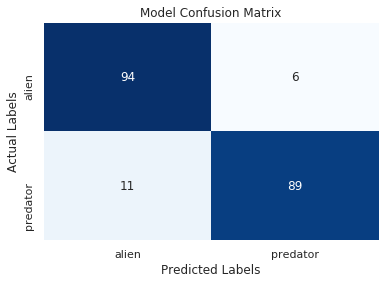

In [0]:
model_report(test_labels, test_predictions, n_classes, classes, all_metrics=True)